In [2]:
#use some personalized power spec with camb
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.8 installed at /home/joline/.local/lib/python3.10/site-packages/camb


In [3]:
#custom  power spectrum function ( power law with one wavepacket)
def PK(k, As, ns, amp, freq, wid):
    return As*(k/0.05)**(ns-1)*(1+ np.sin(k*freq)*amp*np.exp(-k**2/wid**2))

#exponential cutoff
def PK_exp(k, As, ns, kc, alpha):
    return As*(k/0.05)**(ns-1)*(1-np.exp(-(k/kc)**alpha))

#logarithmic oscillation model
def PK_log(k, As, ns, amp, freq, phase):
    return As*(k/0.05)**(ns-1)*(1+amp*np.cos(phase+np.log(k/0.05)*freq))

#logarithmic oscillation model with exp cut off
def PK_log2(k, As, ns, amp, freq, wid):
    return As*(k/0.05)**(ns-1)*(1+amp*np.cos(np.log(k/0.05)*freq)*np.exp(-k**2/wid**2))


#power law+ local peak
def PK_local(k, As, ns, amp,center, width):
    return As*(k/0.05)**(ns-1)*(1+amp*np.exp(-(np.log(k)-np.log(center))**2/(2*width**2)))

#power law+ 2 local peak
def PK_local2(k, As, ns, amp,center, width, amp2, center2):
    return As*(k/0.05)**(ns-1)*(1+amp*np.exp(-(np.log(k)-np.log(center))**2/(2*width**2))+amp2*np.exp(-(np.log(k)-np.log(center2))**2/(2*width**2)))

A_s=2.e-9 #params from topology code
n_s=0.965

#Check how this looks compared to power law
ks = np.linspace(0.00008,0.005,50000)

Text(0.5, 1.0, 'Scalar initial power spectrum')

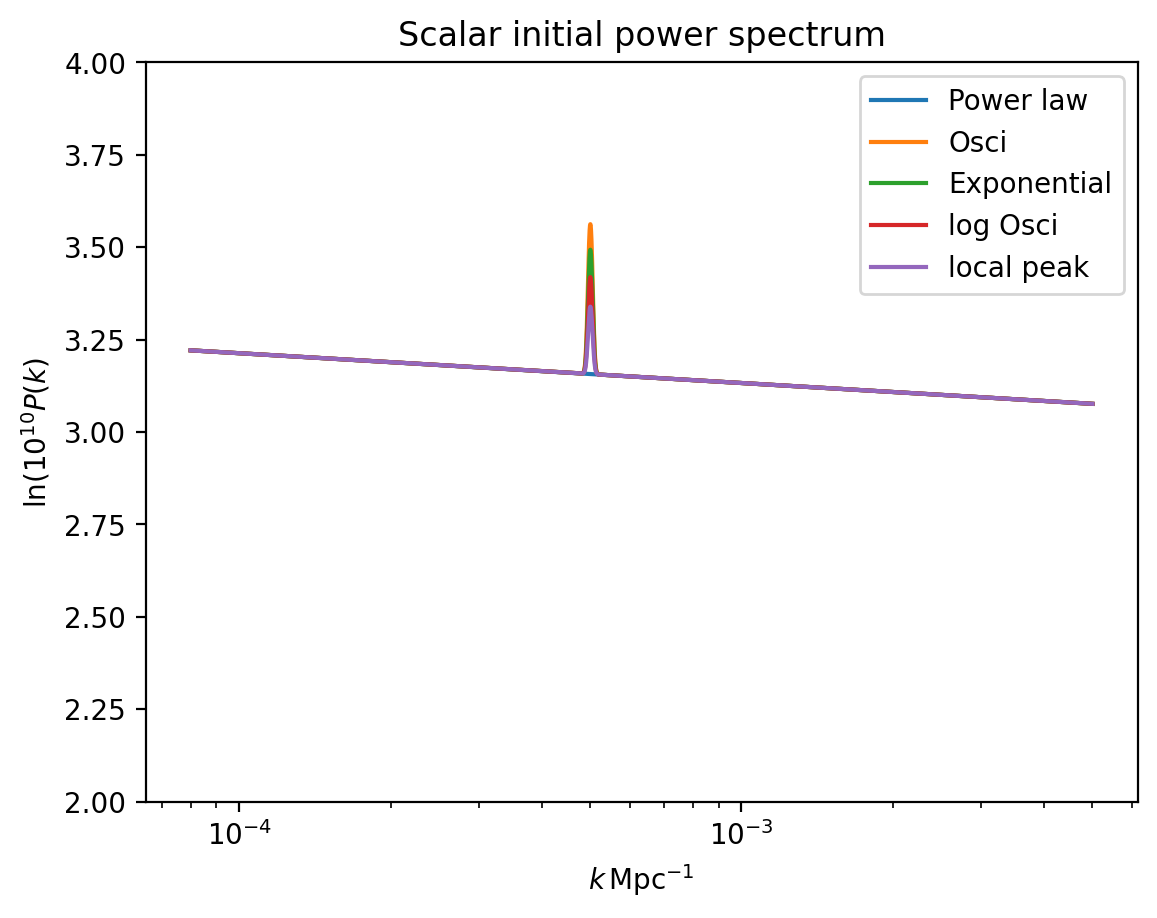

In [12]:
#make plots for the tested parameters


pk1 = A_s*(ks/0.05)**(n_s-1)
#pk2 = PK(ks,A_s, n_s,0.1, 1e4, 0.001) #bigger than planck param space
#pk3 = PK_exp(ks,A_s, n_s,0.0004, 2.)
#pk4 = PK_log(ks,A_s, n_s,0.05, 5,0) #from euclid paper
pk2= PK_local(ks,A_s,n_s, 0.5,5e-4, 0.01)
pk3= PK_local(ks,A_s,n_s, 0.4,5e-4, 0.01)
pk4= PK_local(ks,A_s,n_s, 0.3,5e-4, 0.01)
pk6= PK_local(ks,A_s,n_s, 0.2,5e-4, 0.01)
plt.semilogx(ks,np.log(10**10*pk1))
plt.semilogx(ks,np.log(10**10*pk2))
plt.semilogx(ks,np.log(10**10*pk3))
plt.semilogx(ks,np.log(10**10*pk4))
plt.semilogx(ks,np.log(10**10*pk6))
plt.ylim(2, 4)
plt.ylabel(r'$\ln (10^{10}P(k)$')
plt.xlabel(r'$k\, {\rm Mpc^{-1}}$')
plt.legend(['Power law', 'Osci', 'Exponential', 'log Osci', 'local peak'])
plt.title('Scalar initial power spectrum')
#plt.savefig('PowSpec.pdf')

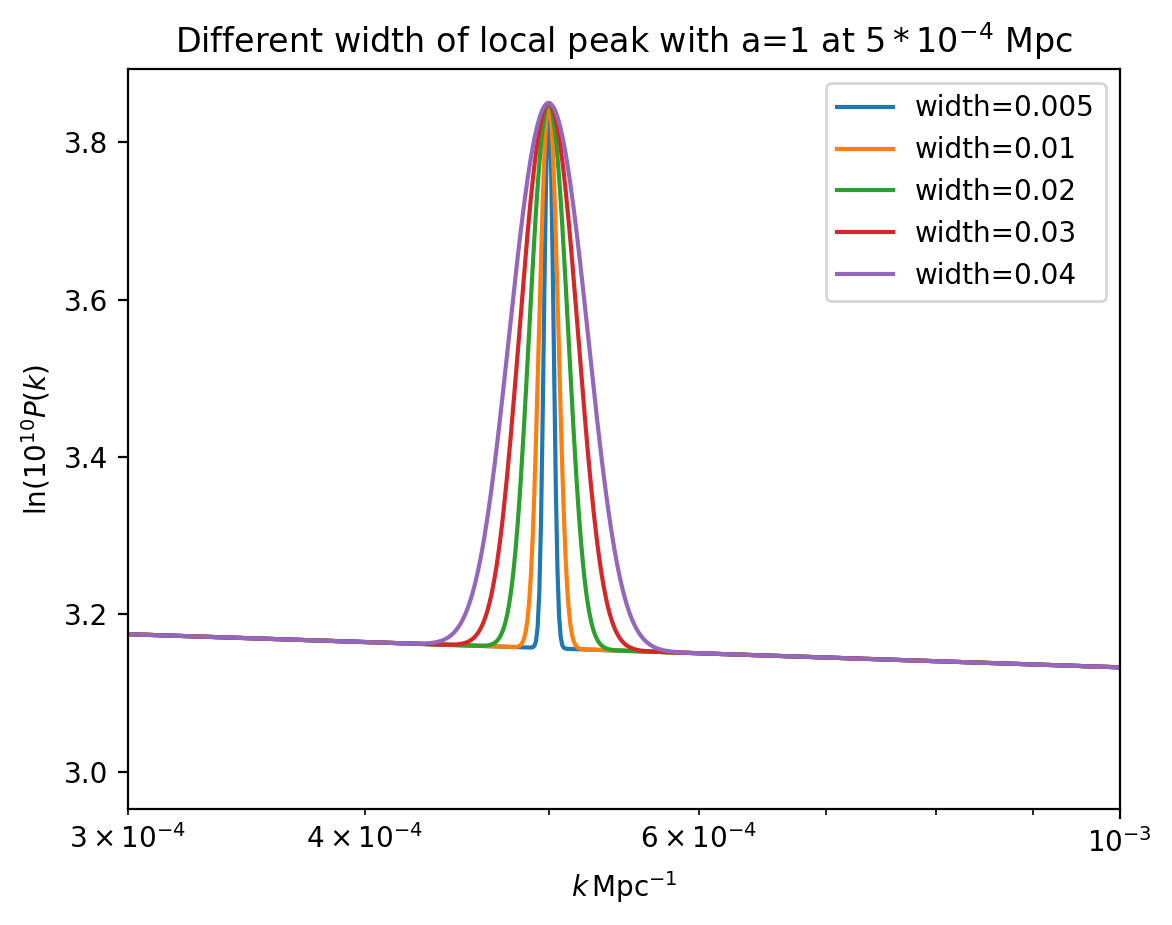

In [44]:
#plot with different width
plt.figure()
for w in [0.005, 0.01, 0.02, 0.03, 0.04 ]:
    plt.plot(ks, np.log(10**10*PK_local(ks,A_s,n_s, 1.,5e-4, w)), label=f'width={w}')

#plt.ylim(2, 4)
plt.xlim(0.0003, 0.001)
plt.xscale('log')
#plt.xticks([0.0002, 0.0005, 0.001], [0.0002, 0.0005, 0.001])
plt.ylabel(r'$\ln (10^{10}P(k)$')
plt.xlabel(r'$k\, {\rm Mpc^{-1}}$')
plt.legend()
plt.title(r'Different width of local peak with a=1 at $5*10^{-4}$ Mpc')
#plt.savefig('peak_width.pdf')
plt.show()

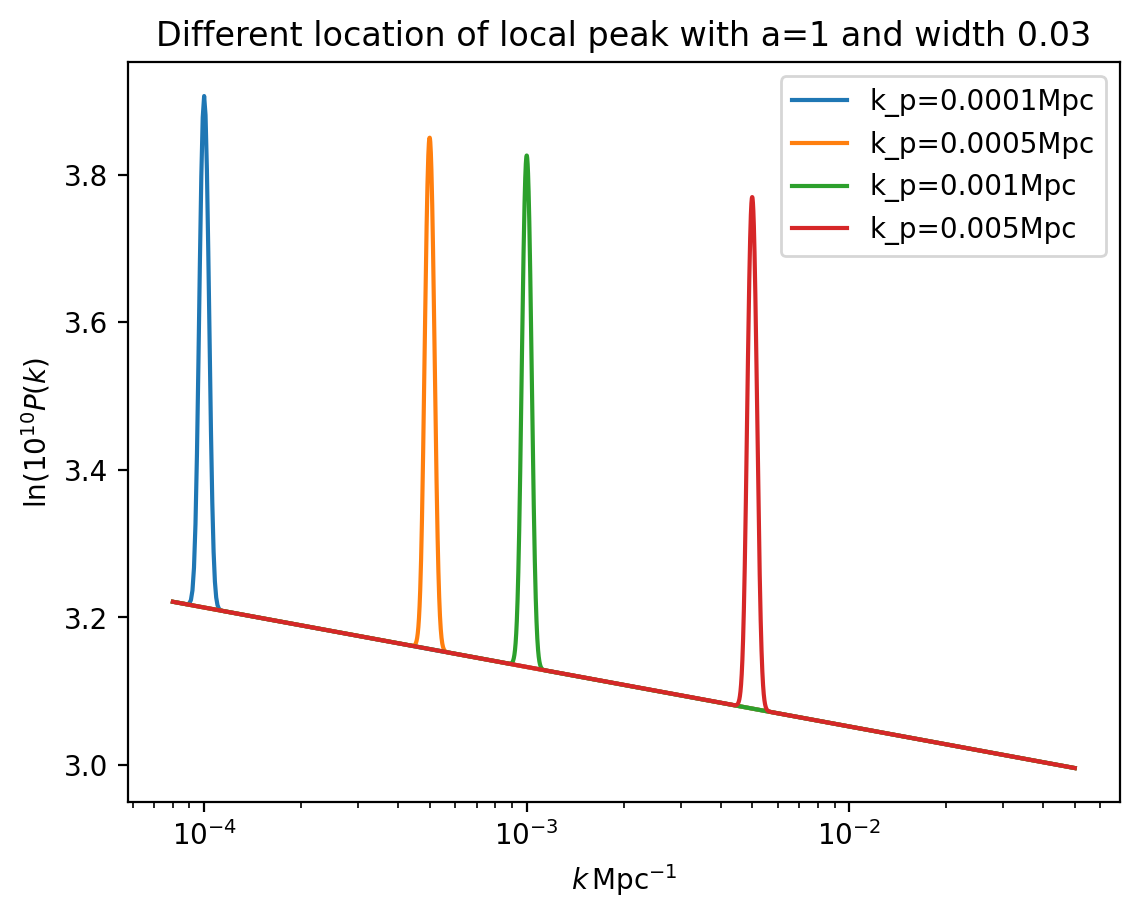

In [47]:
#plot with different location
plt.figure()
for l in [1e-4, 5e-4, 1e-3, 5e-3]:
    plt.plot(ks, np.log(10**10*PK_local(ks,A_s,n_s,1.,  l, 0.03)), label=f'k_p={l}Mpc')

#plt.ylim(2, 4)
#plt.xlim(0.0003, 0.001)
plt.xscale('log')
#plt.xticks([0.0002, 0.0005, 0.001], [0.0002, 0.0005, 0.001])
plt.ylabel(r'$\ln (10^{10}P(k)$')
plt.xlabel(r'$k\, {\rm Mpc^{-1}}$')
plt.legend()
plt.title(r'Different location of local peak with a=1 and width 0.03')
#plt.savefig('peak_location.pdf')
plt.show()

In [3]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
lmax=20
pars.set_for_lmax(lmax)

# More accurate transfer functions. Takes longer time to run
pars.set_accuracy(AccuracyBoost = 2, lAccuracyBoost = 2, lSampleBoost = 50) #last should be 50
pars.Accuracy.IntkAccuracyBoost = 2
pars.Accuracy.SourcekAccuracyBoost = 2

#standard power law
pars.InitPower.set_params(As=A_s, ns=n_s)

# Get the CAMB functions and save them
data = camb.get_transfer_functions(pars)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, raw_cl=True, CMB_unit='muK')['lensed_scalar']
transfer = data.get_cmb_transfer_data(tp='scalar')
#print(r'Calculated L: %s'%transfer.L)

In [5]:
#Now get osci spectrum 
pars.set_initial_power_function(PK, args=(A_s, n_s,0.1, 2e4, 0.001))

# Get the CAMB functions and save them
data2 = camb.get_transfer_functions(pars)
results2 = camb.get_results(pars)
powers2 = results2.get_cmb_power_spectra(pars, raw_cl=True, CMB_unit='muK')['lensed_scalar']
transfer2 = data2.get_cmb_transfer_data(tp='scalar')

In [6]:
#Now get exp cut off spectrum 
pars.set_initial_power_function(PK_exp, args=(A_s, n_s,0.0001, 3.35))

# Get the CAMB functions and save them
data3 = camb.get_transfer_functions(pars)
results3 = camb.get_results(pars)
powers3 = results3.get_cmb_power_spectra(pars, raw_cl=True, CMB_unit='muK')['lensed_scalar']
transfer3 = data3.get_cmb_transfer_data(tp='scalar')

In [7]:
#log oscillation
pars.set_initial_power_function(PK_log, args=(A_s, n_s,0.01, 10,0))

# Get the CAMB functions and save them
data4 = camb.get_transfer_functions(pars)
results4 = camb.get_results(pars)
powers4 = results4.get_cmb_power_spectra(pars, raw_cl=True, CMB_unit='muK')['lensed_scalar']
transfer4 = data4.get_cmb_transfer_data(tp='scalar')

In [17]:
#local peak
pars.set_initial_power_function(PK_local, args=(A_s,n_s,1., 5e-4,0.01))

# Get the CAMB functions and save them
data5 = camb.get_transfer_functions(pars)
results5 = camb.get_results(pars)
powers5 = results5.get_cmb_power_spectra(pars, raw_cl=True, CMB_unit='muK')['lensed_scalar']
transfer5 = data5.get_cmb_transfer_data(tp='scalar')

<Figure size 640x480 with 0 Axes>

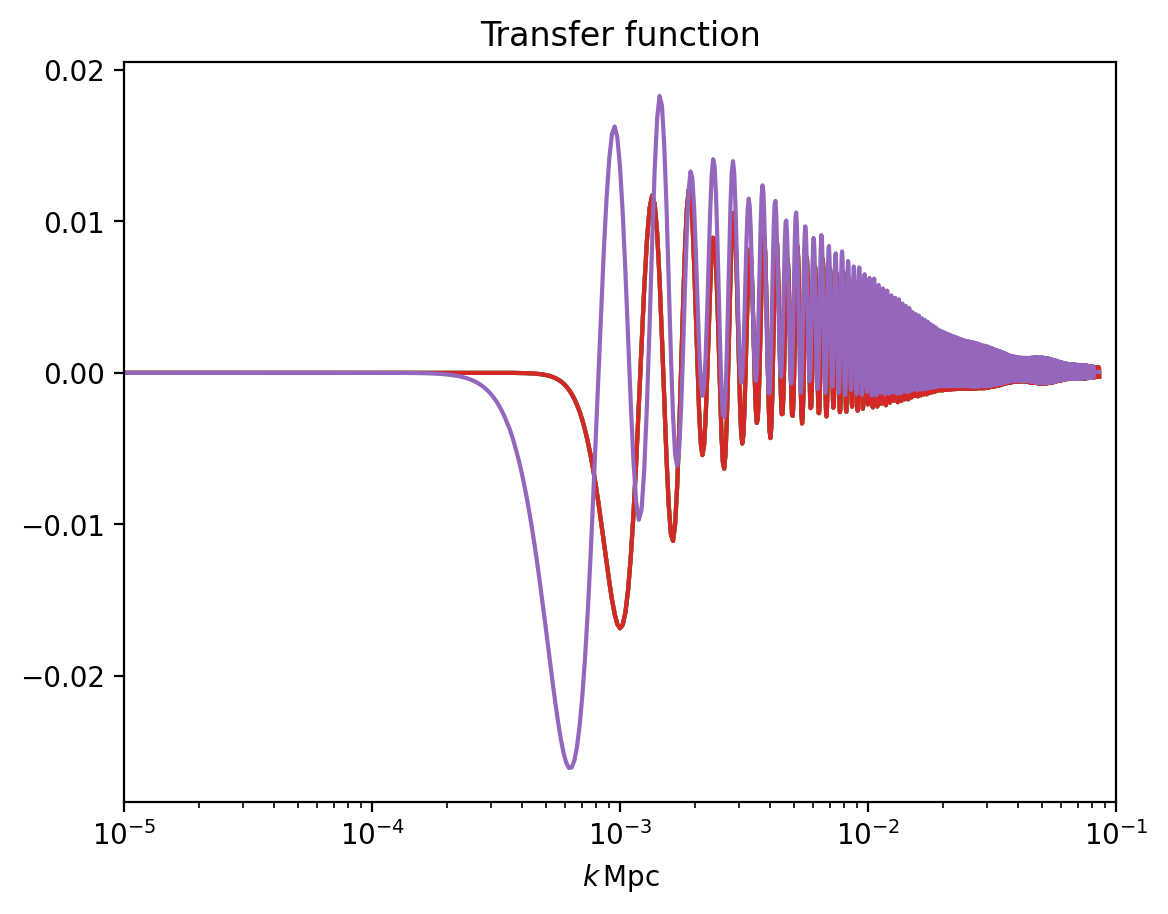

<Figure size 640x480 with 0 Axes>

In [25]:
#take a look at the transfer functions 
plt.semilogx(transfer.q, transfer.delta_p_l_k[0,10,:]) #indexed source (0 for temperature),L,q
plt.semilogx(transfer2.q, transfer2.delta_p_l_k[0,10,:])
plt.semilogx(transfer3.q, transfer3.delta_p_l_k[0,10,:])
plt.semilogx(transfer4.q, transfer4.delta_p_l_k[0,10,:])
plt.semilogx(transfer5.q, transfer5.delta_p_l_k[0,5,:])
plt.xlim([1e-5, 0.1])
plt.xlabel(r'$k\, {\rm Mpc}$');
plt.title('Transfer function')
plt.figure()

<Figure size 640x480 with 0 Axes>

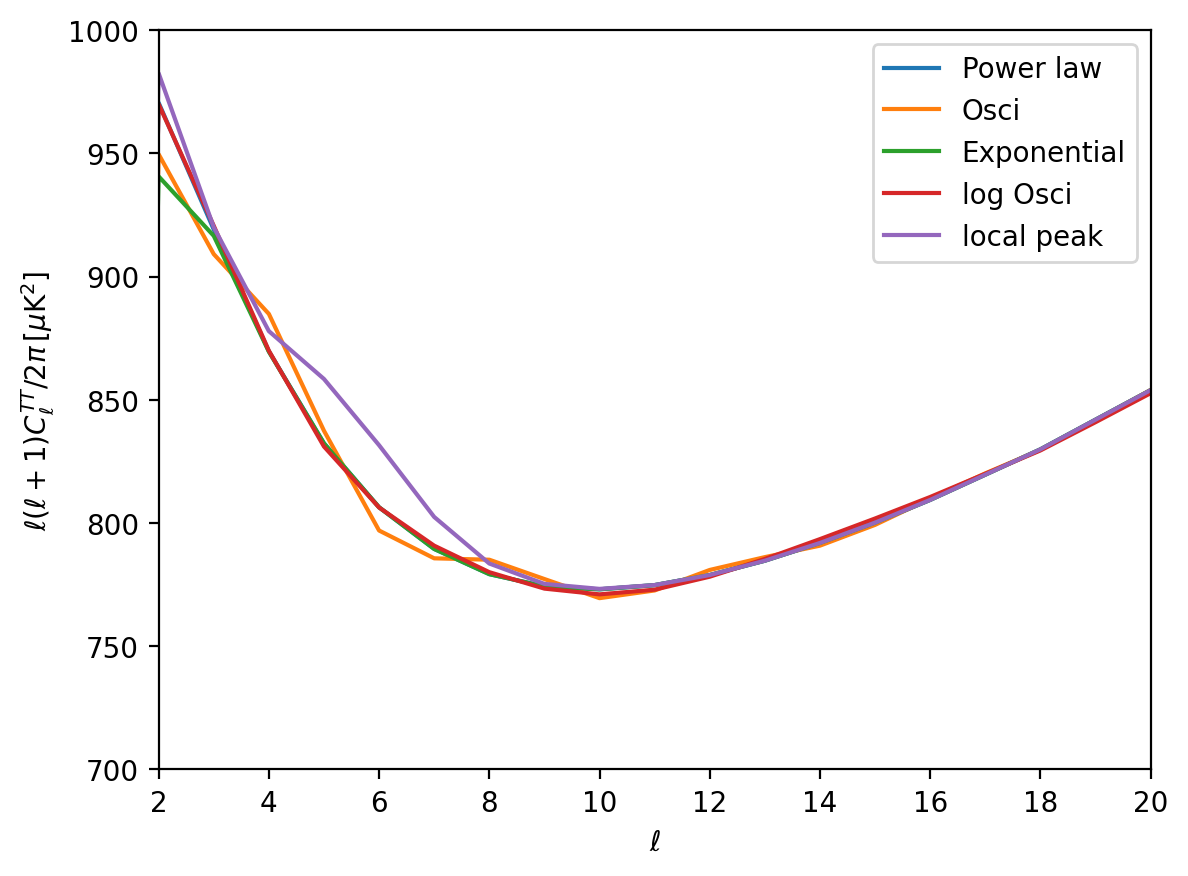

<Figure size 640x480 with 0 Axes>

In [20]:
#CAMB's output for the power spectrum
CL=powers
CL2=powers2
CL3=powers3
CL4=powers4
CL5=powers5
ls = np.arange(CL.shape[0])
plt.plot(ls,CL[:,0]*ls*(ls+1)/(2*np.pi))
plt.plot(ls,CL2[:,0]*ls*(ls+1)/(2*np.pi))
plt.plot(ls,CL3[:,0]*ls*(ls+1)/(2*np.pi))
plt.plot(ls,CL4[:,0]*ls*(ls+1)/(2*np.pi))
plt.plot(ls,CL5[:,0]*ls*(ls+1)/(2*np.pi))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell^{TT}/2\pi\,[\mu {\rm K}^2]$')
plt.xlim(2,lmax)
plt.ylim(700,1000)
plt.legend(['Power law', 'Osci', 'Exponential', 'log Osci', 'local peak'])
#plt.savefig('powSpecCl.pdf')
plt.figure()

<Figure size 640x480 with 0 Axes>

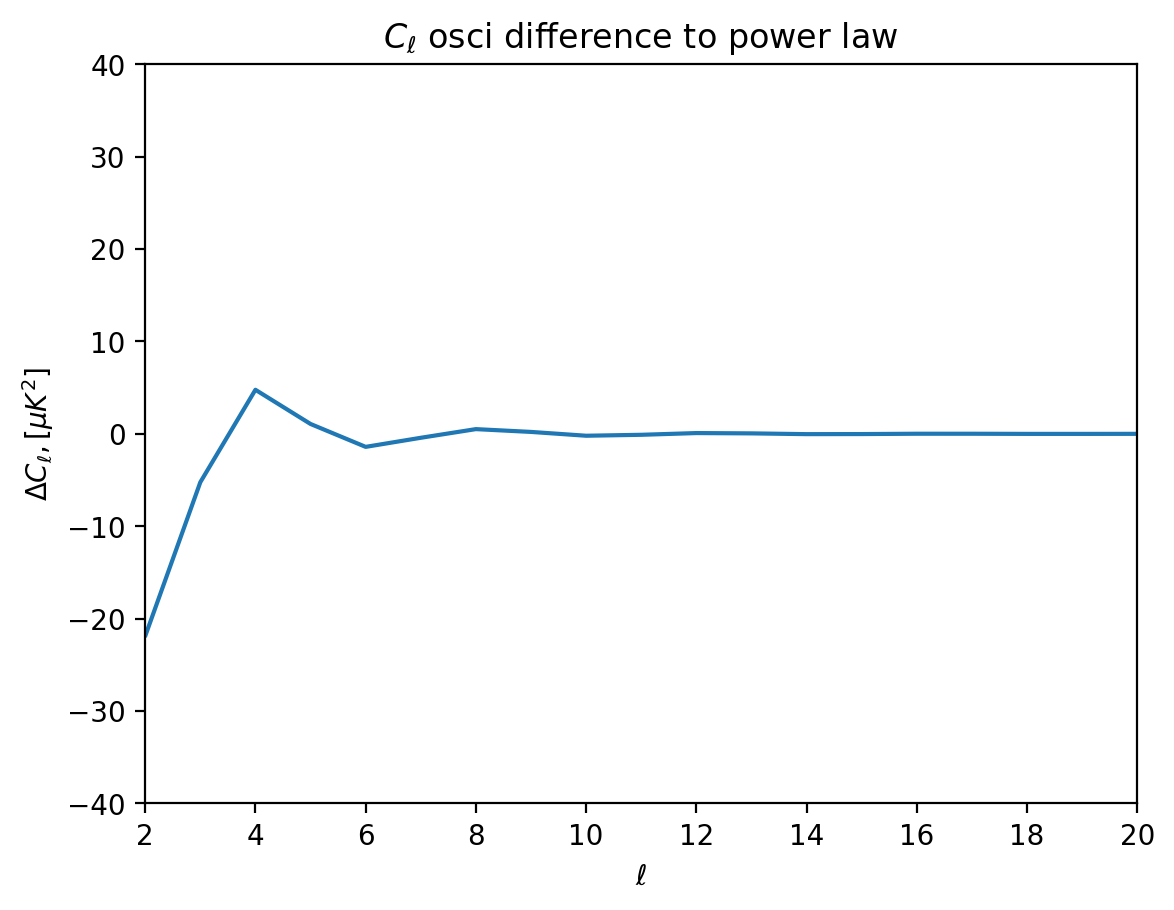

<Figure size 640x480 with 0 Axes>

In [13]:
#look at the difference with oscillation
plt.plot(ls,(CL2[:,0]-CL[:,0]))
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\Delta C_\ell, [\mu K^2]$')
plt.xlim(2,lmax)
plt.ylim(-40,40)
plt.title(r'$C_\ell$ osci difference to power law')
plt.figure()

<Figure size 640x480 with 0 Axes>

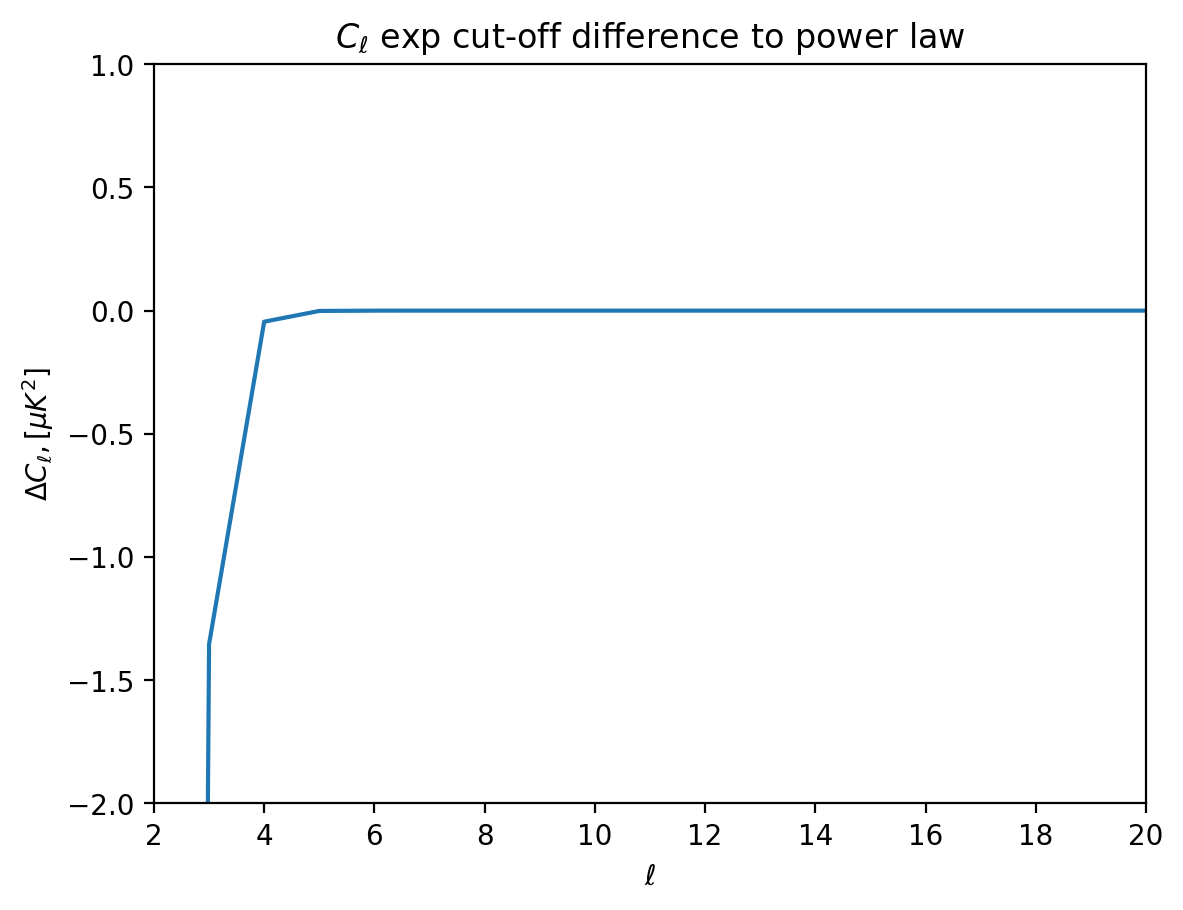

<Figure size 640x480 with 0 Axes>

In [14]:
#look at the difference with exp cut off
plt.plot(ls,(CL3[:,0]-CL[:,0]))
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\Delta C_\ell, [\mu K^2]$')
plt.xlim(2,lmax)
plt.ylim(-2,1)
plt.title(r'$C_\ell$ exp cut-off difference to power law')
plt.figure()

<Figure size 640x480 with 0 Axes>

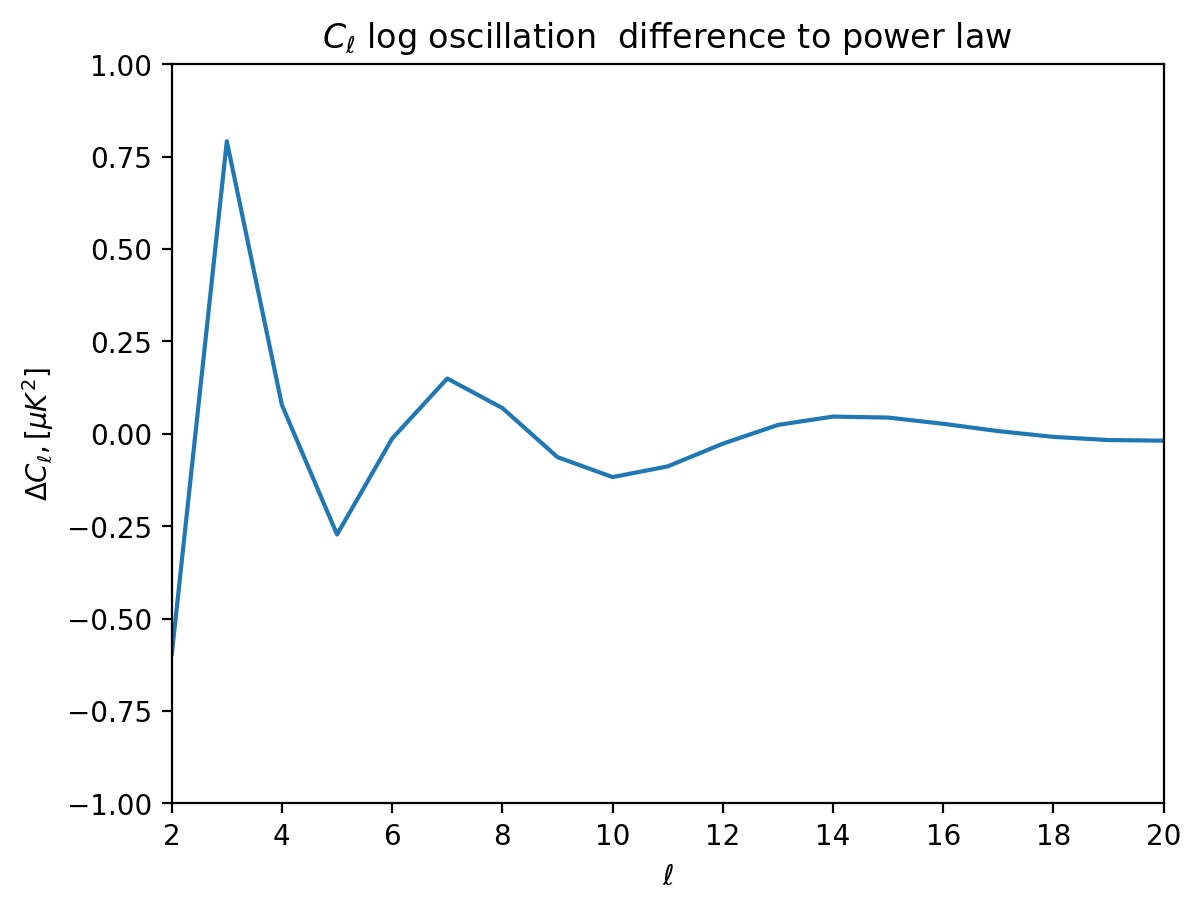

<Figure size 640x480 with 0 Axes>

In [15]:
#look at the difference with osci2
plt.plot(ls,(CL4[:,0]-CL[:,0]))
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\Delta C_\ell, [\mu K^2]$')
plt.xlim(2,lmax)
plt.ylim(-1,1)
plt.title(r'$C_\ell$ log oscillation  difference to power law')
plt.figure()

<Figure size 640x480 with 0 Axes>

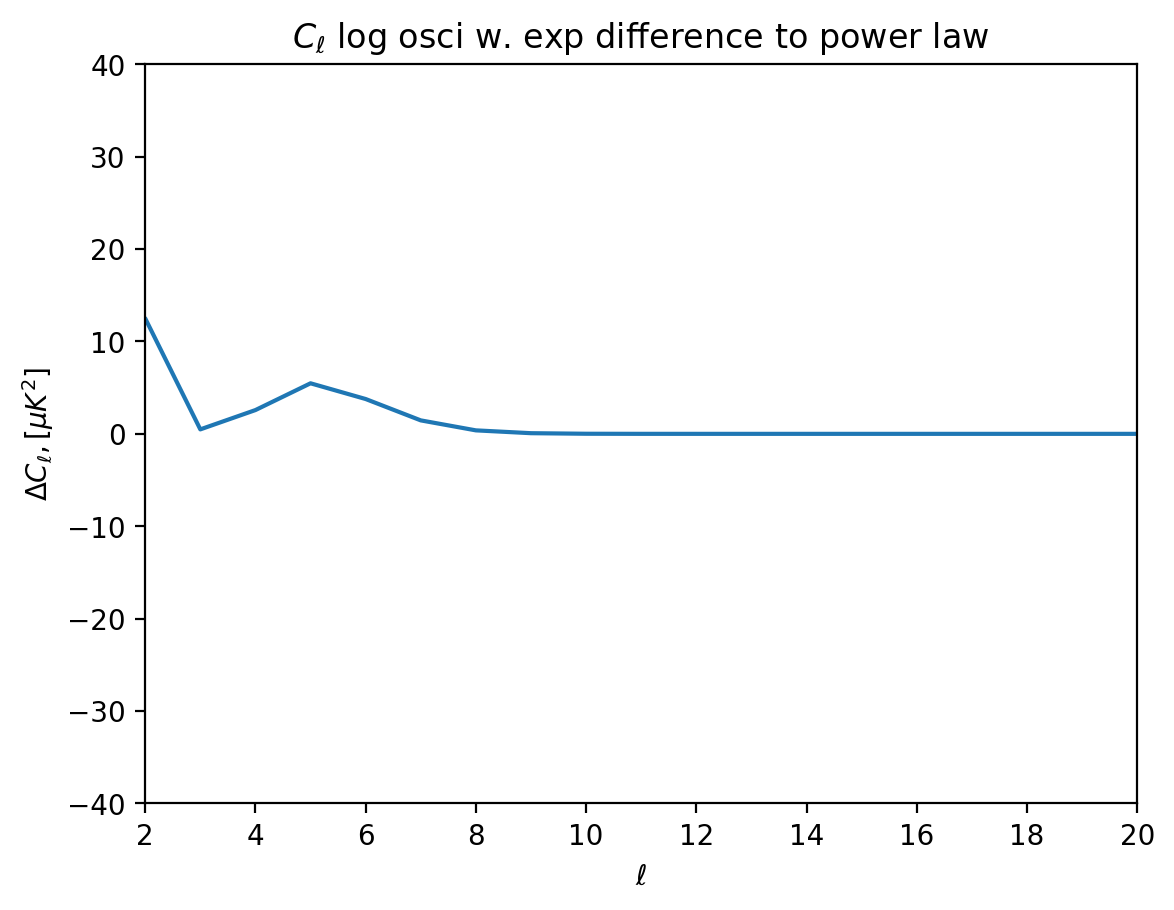

<Figure size 640x480 with 0 Axes>

In [21]:
#look at the difference with local peak
plt.plot(ls,(CL5[:,0]-CL[:,0]))
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\Delta C_\ell, [\mu K^2]$')
plt.xlim(2,lmax)
plt.ylim(-40,40)
plt.title(r'$C_\ell$ log osci w. exp difference to power law')
plt.figure()